In [1]:
import torch
import torchvision 

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2a0


importing codes weve written in previous sections

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine



/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## get data

In [4]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/blob/cdc0a0a544a743099f38e08948cb8790ae6867f9/data/pizza_steak_sushi.zip

--2023-09-29 15:05:52--  https://github.com/mrdbourke/pytorch-deep-learning/blob/cdc0a0a544a743099f38e08948cb8790ae6867f9/data/pizza_steak_sushi.zip


Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6659 (6.5K) [text/plain]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]   6.50K  --.-KB/s    in 0s      

2023-09-29 15:05:52 (40.4 MB/s) - ‘pizza_steak_sushi.zip’ saved [6659/6659]



In [5]:
import os 
import zipfile

from pathlib import Path

import requests

#seetup data path 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" #images froma  subest of classes from food101

#if the image folder dont exist thend own from githu b
if image_path.is_dir():
    print(f"{image_path} dir already exists dskipping redownload...")
else:
    print(f"{image_path} not found, downloading it")
    image_path.mkdir(parents=True,
                     exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as file:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"downloading piza, steak and sushi data...")
        file.write(request.content)
        
        #unzip the dataset
        with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
            print(f"unzipping pizza steak and sushi data")
            zip_ref.extractall(image_path)
            
        os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi dir already exists dskipping redownload...


In [6]:
#import helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print(f"'helper_function.py' already exists skipping donwload.")
else:
    print(f"downloading helper_functions.py")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)
 
import helper_functions       
    

'helper_function.py' already exists skipping donwload.


In [7]:
#setup direcoty path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## create datasets andd dataloders
#### we can use the data_setup.py for it 
one think we have to think about when loading data is how to transform the data and with 
`torchvision 0.13+` theres 2 ways to do this 
1. manually created transforms - you define what transform you want your data to go through
2. autoamtically created transforms - the transform for  your data are defined by the model you'f like to use


**important note**: when usiing a pretrainned molde it s importnat that the data
(includin custom dataset) that you pass thourgh it is **transformed** the same way that the data the model was trained on 

## manually creating a transforms for `torchvision.models`
`torchvision.models` contains pretrained models (models ready for tranfer learning) withn torchvision

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                 std=(0.229, 0.224, 0.225))

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)), #resze image to 224,224 #ome models may requeire diffrent weights
    transforms.ToTensor(), # image to range [0,1]
    normalize #imge have same distribution as Imagenet where our pretrained models have been trained
])

In [9]:
from going_modular.going_modular import data_setup
import os
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f30c0f7e210>,
 ['pizza', 'steak', 'sushi'])

## automatically creating transforms for `torchvision.models`

In [10]:
## creating a transform for `torchvision.models` (auto creatino)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT = 'beste availabel weights'
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
#get the transformes used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
#craete dadtaloaders usign automatic transforms 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f30c0df5590>,
 ['pizza', 'steak', 'sushi'])

>## getting a pretrained model
1. pytorch domain libraries
2. `timm` (torch image models)
3. huggingface hub (for plenty of diffrent models)
4. paparswithcode ( for amodels across different probelem spaces/domains)

which model to use?
* experiment

transfer learnign: taking an already well-performing modelfrom aproblem sapce imilar to your owna nd then customize to your own porblem.
things to consider: 
- speed -> how fast?
- size -> how big is the model?
- performance -> how well does it go on your problem 

where does the model live?
- is it on device(like a self driving car)
- or does it live on server 

looking at `https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights`

which model should we choose
- higher params means higher inference time
- acc@1 is the highest accuracy if considering first pred

look for : best trade-off highest accuracy between lowest params

>### looks like effnetb0 is one of our best options in terms of performance vs size. since we want our model deployed in a mobile device.

However in light of the bitter lesson, if we had infiinte comput ewe'd likely pick the biggest model +most parameters + most general we could


## old method of setting up a pretrainnedd model

In [13]:
# setting up a pretrained model  (old) prior 0.13

model = torchvision.models.efficientnet_b0(pretrained=True)


/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## new method of created a pretrained model(afteer 0.13)

In [14]:
#new method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #default are theest available wiehts
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [18]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

/usr/lib/python3.11/site-packages/torchinfo/torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

># different types of transfer learning 
>## original model -> feature extraction model -> fine tuned model

In [19]:
from torchinfo import summary
summary(model, 
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## for feature extraction we wanna freeze the base layers/backbone and change the classifier block to suit our problem
## so they dont update during weights during traingin when we train on our own data

Requires grd is a attriute of a paramters ie pytorch is ging to tarck the gradients of a parameter() it uses the optimzer to tweak the paramter to better suit the data 
setting req grad to faslse means pytorch wont track the gradient and wont update them with the optimizer during training 

In [20]:
### freezing the base model and changing the output layer to suit our needs (feature extraction tranfer learning)
for param in model.features.parameters():
    param.requires_grad = False #requiresgrad is an attribute of a param where it uses the optimzer to update the 
    #torch.inferencemode() kinda does the same thing
    #print(param)

In [21]:
from torchinfo import summary
summary(model, 
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### we have frozen all the base layers/ that is made them untrainable 
### but the output layer is still trainable

## update the classifier head to suit our proobelm

In [22]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [23]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True), #regualization method by drpoping out neurons on random
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True) #3 output to fit our food problem
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

## updated outfeaatures

In [24]:
summary(model, 
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## training mdoel

In [25]:
#define loss and optimzaer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

In [26]:
#using train.py from going_modular
from going_modular.going_modular import engine

#set mandual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

Epoch: 2 | train_loss: 0.8707 | train_acc: 0.7695 | test_loss: 0.7918 | test_acc: 0.8456


 60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

Epoch: 3 | train_loss: 0.7686 | train_acc: 0.7930 | test_loss: 0.7461 | test_acc: 0.8352


 80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

Epoch: 4 | train_loss: 0.7167 | train_acc: 0.7422 | test_loss: 0.6370 | test_acc: 0.8759


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

Epoch: 5 | train_loss: 0.6292 | train_acc: 0.7695 | test_loss: 0.6272 | test_acc: 0.8968
[INFO] total training time: 10.545 seconds


In [27]:
#to plot loss curves use helper_functions
#import helper functions
import requests
from pathlib import Path

try:
    import helper_functions
except:
    print("failed the try") 
    print(f"download helper_fucntions")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)
    import helper_functions  


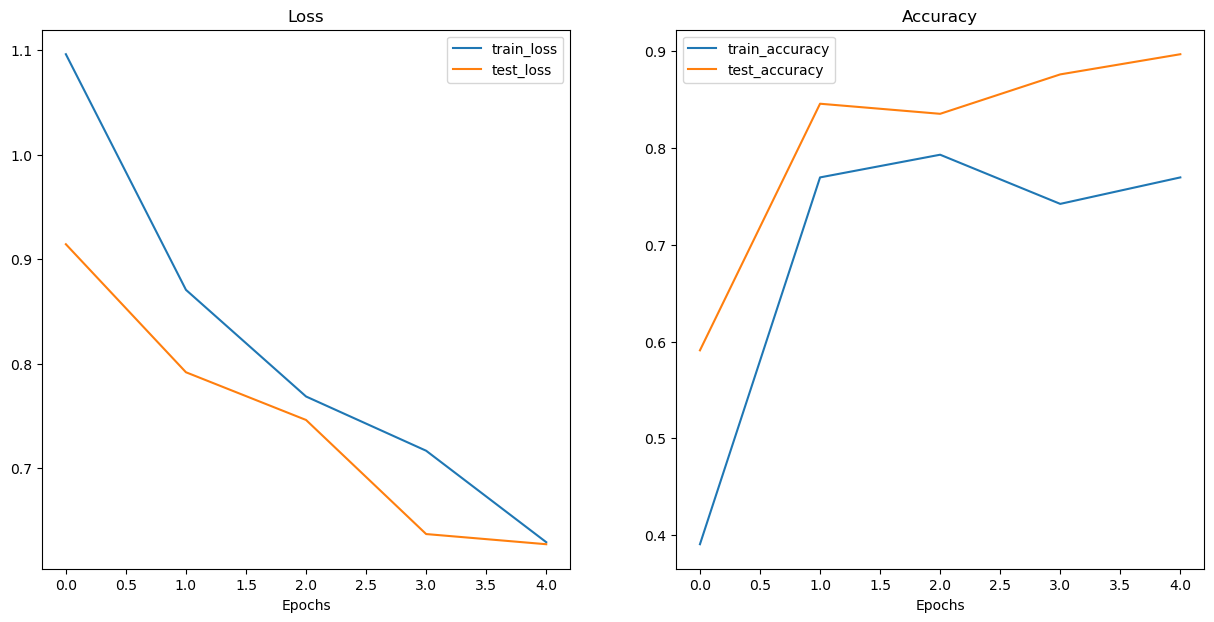

In [28]:
helper_functions.plot_loss_curves(results=results)

## we could train for longer

>## make predictions on images fromm the test set
let's adhere to the data exploere's moto
and mkae some qualititavie preds on our test set.
some things to keep in mind when making prediaatin.onference on testdata / custo data

We have to make sure that our test/custom data is: (properly formatted)
* same shape = imageneed to same shape as model was trainied on
* same datatype custom data should be the same data type
* same ddevice custom and test data shoudl be on the same model
* same tranforms if your've tranformed you rcustom data, ideally you willl need to tranform the test data dn custom data the same 

## to do all of this autoamatically let's create a fucntion  called `pred_and_plot_image()`

In [29]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
    #2open img with pil
    img = Image.open(image_path)
    #3craet a transform if one doesn't exist
    if transform is not None: # or if transform:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                 std=(0.229, 0.224, 0.225))
        ])
    #pred on image
    #4 amke sure the model is on the target device
    model.to(device)
    model.eval()
    with torch.inference_mode():
        #transform the iamge and add an extra batch dimension as expected by the model
        transformed_image = image_transform(img).unsqueeze(dim=0)
        
        #7 make a pred on the tranformed image by passing it thourght the model (also ensure its on target device)
        target_image_pred = model(transformed_image.to(device))
        target_image_probs = torch.softmax(target_image_pred, dim=1)
        # print(target_image_probs)
        target_image_label = torch.argmax(target_image_probs, dim=1)
        
    #plot the image with the pred label and prob
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_label]} | prob: {target_image_probs.max():.3f}")
    plt.axis(False)    

In [34]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

[PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]


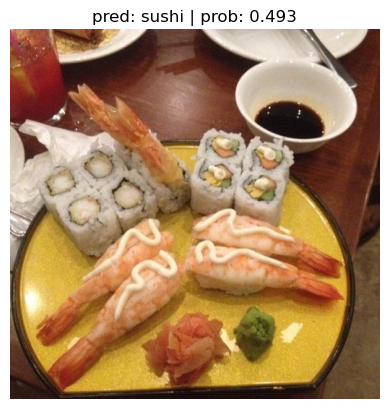

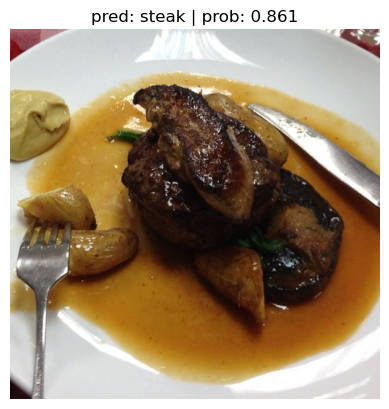

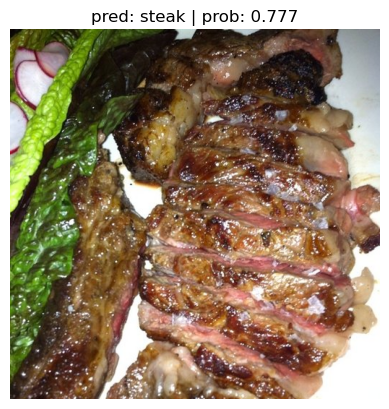

In [37]:
#get random imamges from teh test dataset:
import random
num_of_images_to_plot = 3
test_images_path_list = list(Path(test_dir).glob("*/*.jpg"))
len(test_images_path_list)
test_image_path_sample = random.sample(population=test_images_path_list,
                                       k=num_of_images_to_plot)
print(test_image_path_sample)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

In [32]:
### mkaing preds on a custom image `pizza-dad`
#downlaod the image if its not here
import requests
from pathlib import Path
#setup custom iamge path
custom_image_path = data_path / "pizza_dad.jpeg"

#downlaod the iamg if it doenst exist
if not custom_image_path.is_file():
    print(f"image found downloading")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg?raw=true")
    with open(custom_image_path, "wb") as file:      
        file.write(request.content)
        
else:
    print(f"{custom_image_path} already exists skipping download...")

data/pizza_dad.jpeg already exists skipping download...


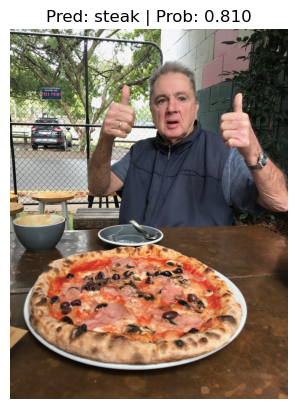

In [36]:
#predict on custom image
helper_functions.pred_and_plot_image(model=model,
                                     image_path=custom_image_path,
                                     class_names=class_names)

bruh